In [1]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib import pyplot as plt

import seaborn as sns
import pandas as pd
import feather
import os.path

from polya.utils import smooth

sample = "HeLa"

In [2]:
datadir = "../data/external/pal-seq"

fname = {
    "HeLa": "GSM1316813_HeLa_total_PAL.tsv",
    "HeLa-Cyt": "GSM1316812_HeLa_PAL.tsv",
    "3T3": "GSM1316801_3T3_PAL.tsv",
    "HEK293T": "GSM1316800_Hek293T_PAL.tsv",
}[sample]

fpath = os.path.join(datadir, fname)
print( fpath )


../data/external/pal-seq/GSM1316813_HeLa_total_PAL.tsv


In [3]:
df = pd.read_csv(fpath, sep="\t", index_col=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,0,0,0,0,0,0,0,0,0,0,...,2,4,0,0,0,0,0,0,0,0
ENSG00000000457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000971,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Global poly(A) length of a sample, w/ and w/o mitochondrial genes

In [4]:
genepath = "/casa/joha/scripts/tailseeker3.1.7/refdb/level3/GRCh38/annotations-gene.feather"
df_gene = feather.read_dataframe(genepath)

# Mitochondrially-encoded genes
df_mtgenes = df_gene[df_gene["seqname"].map(lambda x: x == "chrM" if x else False)]
mtgenes = df_mtgenes["gene_id"]
mtgenes = mtgenes.append(pd.Series(['ENSG00000247627.2', 'ENSG00000248527.1']) ) # adding MTND4P12, MTATP6P1 pseudogenes
mtgenes = mtgenes.map(lambda x: x.split('.')[0])
print( len(mtgenes), "MT-encoded genes")

# TOP genes: The list is from Yamashita et al., NAR, 2008
topglist = [g.strip().upper() for g in open("../data/external/human_top_genes_nar_2008.csv", "rt").readlines()]
df_topgenes = df_gene[df_gene["gene_name"].isin(topglist)]
topgenes = df_topgenes["gene_id"]
print( len(topgenes), "TOP genes" )

# RP genes
df_rpgenes = df_gene[df_gene["gene_description"].map(lambda x: x.startswith("ribosomal protein") if x else False)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "kinase" not in x)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "like" not in x)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "binding" not in x)]
print(len(df_rpgenes), "RP genes")
rpgenes = df_rpgenes["gene_id"]

gene_subsets = {
    'mtgenes': mtgenes,
    'topgenes': topgenes,
    'rpgenes': rpgenes,
}

39 MT-encoded genes
89 TOP genes
1177 RP genes


/utp/joha/miniconda3/envs/polya/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [5]:
drop_mtgenes=True
df_wo_mt = df.drop(mtgenes, errors="ignore")
print( len(df), len(df_wo_mt) )

12374 12337


../plots/global_pAlen_dists_HeLa_PAL-seq_10-220_wo_mtgenes_mini.pdf


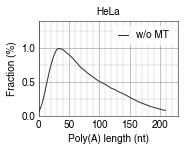

In [6]:
savefig = True
minifig = True

figsize = 5, 3.5
smoothing = True
pAlen_range = [10, 220]; pr=pAlen_range
fmax=None

styles = ["../polya.mplstyle"]
if minifig is True: 
    styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))
    
with plt.style.context(styles):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
        
    pAlen_dist = df.sum().iloc[pr[0]:pr[1]]
    pAlen_dist = pAlen_dist / pAlen_dist.sum() * 100 # fraction in percent
    pAlen_dist_wo_mt = df_wo_mt.sum().iloc[pr[0]:pr[1]]
    pAlen_dist_wo_mt = pAlen_dist_wo_mt / pAlen_dist_wo_mt.sum() * 100
    
    if smoothing is True:
        pAlen_dist = smooth(np.array(pAlen_dist), window_len=11)
        pAlen_dist_wo_mt = smooth(np.array(pAlen_dist_wo_mt), window_len=11)

    
    if fmax is None: fmax = pAlen_dist.max()
    elif fmax < pAlen_dist.max(): fmax = pAlen_dist.max()
    
#     ax.plot(pAlen_dist, label="Total")
    ax.plot(pAlen_dist_wo_mt, label="w/o MT")
    
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2)) 
    ax.xaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.xaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.yaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.yaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.set_xlim([0,230])
#     ax.set_ylim([0, np.round(fmax * 1.1, 1)])
    ax.set_ylim([0,1.4])
    ax.set_xticks(range(0,250,50))
    ax.legend(loc="upper right", fontsize="medium", handlelength=1.0)#, ncol=2, columnspacing=0.1)
#     ax.legend(loc="center left", bbox_to_anchor=[1.01,0.5])
    ax.set_xlabel("Poly(A) length (nt)")
    ax.set_ylabel("Fraction (%)")
    ax.set_title("{}".format(sample), fontsize="medium")
    
    fname_adduct = ""
    if drop_mtgenes is True: fname_adduct += "_wo_mtgenes"
    if minifig is True: fname_adduct += "_mini"

    if savefig is True:
        outfigpath = "../plots/global_pAlen_dists_{}_PAL-seq_{}-{}{}.pdf".format(sample, pr[0], pr[1], fname_adduct)
        print(outfigpath)
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")
        
    plt.show()

#### Modal poly(A) length scatter

In [28]:
pAlen_range = [10, 220]; pr=pAlen_range
minimum_pAtags = 200
drop_mtgenes = True
np.random.seed(42)

df = pd.read_csv(fpath, sep="\t", index_col=0)
if drop_mtgenes: df = df.drop(mtgenes, errors="ignore")

pAtags = df.iloc[:, pr[0]:pr[1]+1]
pAtags = pAtags[pAtags.sum(axis=1) >= minimum_pAtags]
pAshuffled = pAtags.columns.tolist(); np.random.shuffle(pAshuffled)
pAmodes = pAtags[pAshuffled].apply(pd.Series.idxmax, axis=1).astype(int)
pAmeans = pAtags.multiply(pAtags.columns.astype(int)).sum(axis=1) / pAtags.sum(axis=1) # Arithmatic mean

../plots/modal_vs_mean_pAlen_HeLa_PAL-seq_10-220_wo_mtgenes_mini.pdf


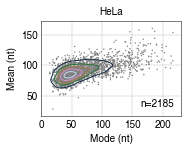

In [31]:
savefig = True
minifig = True

x = pAmodes
y = pAmeans

figsize = 5, 3.5
styles = ["../polya.mplstyle"]
if minifig is True: 
    styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))

with plt.style.context(styles):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    ax.scatter(x, y, s=2, color="grey", edgecolor="none", rasterized=True)
    sns.kdeplot(x, y, n_levels=5, cmap="cubehelix", ax=ax)
    
    ax.text(x=0.95, y=0.1, s="n=%d"%(len(x)), ha="right", transform=ax.transAxes)
    ax.set_xlim([0,230])
    ax.set_xticks(range(0,250,50))
    ax.set_xlabel("Mode (nt)")
    ax.set_ylabel("Mean (nt)")
    ax.set_title(sample, fontsize="medium")
    ax.grid(True)

    fname_adduct = ""
    if drop_mtgenes is True: fname_adduct += "_wo_mtgenes"
    if minifig is True: fname_adduct += "_mini"

    if savefig is True:
        outfigpath = "../plots/modal_vs_mean_pAlen_{}_PAL-seq_{}-{}{}.pdf".format(sample, pr[0], pr[1], fname_adduct)
        print(outfigpath)
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")
        
    plt.show()